In [51]:
from pharynx_analysis import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [52]:
meta_dir = Path("/Users/sean/code/wormAnalysis/data/paired_ratio")

all_mvmt = da.load_all_movement(meta_dir).pivot_table(columns='region', values=['movement'], index=['pair', 'experiment', 'animal']).reset_index()

df = da.load_all_summaries(meta_dir)
df = df.reset_index(drop=True)
# df[df.experiment == '2017_02_22-HD233_SAY47']
df['total'] = df['anterior'] + df['posterior'] + df['sides_of_tip'] + df['tip']
df = df.pivot_table(index=['animal', 'experiment', 'strategy'], columns='pair').reset_index()
df = df.sort_values(['experiment', 'animal'])

df.index.rename('index', inplace=True)
df = df[df.strategy=='single_reg'].reset_index(drop=True)
df.index.rename('index', inplace=True)
df.head()

animal              experiment    strategy          410               \
pair                                                        0            1   
index                                                                        
0          0  2017_02_22-HD233_SAY47  single_reg  7867.316522  7913.949196   
1          1  2017_02_22-HD233_SAY47  single_reg  8240.370640  8628.224280   
2          2  2017_02_22-HD233_SAY47  single_reg  9125.879916  9084.437211   
3          3  2017_02_22-HD233_SAY47  single_reg  8319.834159  8352.095984   
4          4  2017_02_22-HD233_SAY47  single_reg  8490.935634  8318.103119   

               470              anterior              e  ... posterior     \
pair             0            1        0  1           0  ...         0  1   
index                                                    ...                
0      5522.521894  5531.857693        0  0 -270.618116  ...         0  0   
1      5701.835700  5970.328106        0  1 -270.083542  ...         0  1   
2      6679.055468  6569.959972        0  0 -272.164406  ...         0  0   
3      5594.121760  5567.273572        0  0 -269.144020  ...         0  0   
4      5679.523530  5576.936311        0  0 -268.735133  ...         0  0   

              r           sides_of_tip    tip    total     
pair          0         1            0  1   0  1     0  1  
index                                                      
0      1.428143  1.435046            0  0   1  0     1  0  
1      1.449376  1.450312            1  1   0  1     1  4  
2      1.366817  1.382932            0  0   0  0     0  0  
3      1.492789  1.504509            0  0   0  0     0  0  
4      1.511920  1.511042            0  0   0  0     0  0  

[5 rows x 23 columns]

In [53]:
def load_all_cached_profile_data(glob_pattern):
    return xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob(glob_pattern))), dim='strain')

raw_prof = load_all_cached_profile_data('**/*single_unreg/*.nc')
reg_prof = xr.concat((xr.load_dataarray(x) for x in (sorted(Path("/Users/sean/code/wormAnalysis/data/paired_ratio").glob("**/*08-29_skfda_reg/*.nc")))), dim='strain')

In [54]:
regions = {
    'pm3': [.07, .28],
    'pm4': [.33, .45],
    'pm5': [.53, .70],
    'pm6': [.80, .86],
    'pm7': [.88, .96],
}

prof_len = raw_prof.shape[-1]
scaled_regions = {
    region: (prof_len * np.asarray(regions[region])).astype(np.int)
    for region in regions.keys()
}

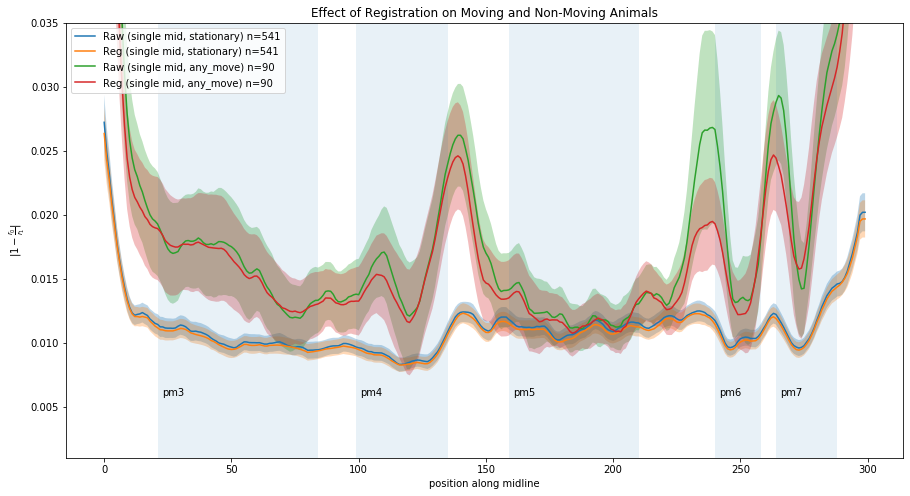

In [57]:
region_of_interest = 'posterior'

nomove =    df[(df['total'][0] == 0) & (df['total'][1] == 0)].index.values
any_move =  df[(df['total'][0] == 0) & (df['total'][1] > 0)].index.values
post_move = df[(df['total'][0] == 0) & (df[region_of_interest][1] > 0)].index.values

fig, ax0 = plt.subplots(1,1,figsize=(15,8))

# Non-moving
plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[nomove], ax=ax0, label=f'Raw (single mid, stationary) n={len(nomove)}')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[nomove], ax=ax0, label=f'Reg (single mid, stationary) n={len(nomove)}')

# Moving
plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[any_move], ax=ax0, label=f'Raw (single mid, any_move) n={len(any_move)}')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[any_move], ax=ax0, label=f'Reg (single mid, any_move) n={len(any_move)}')

ax0.legend(loc='upper left')
ax0.set_ylabel(r'$|1 - \frac{r_0}{r_1}|}$');
ax0.set_xlabel(r'position along midline');
plots.add_regions_to_axis(regions=scaled_regions, ax=ax0)
ax0.set_ylim([.0010, 0.035]);
ax0.set_title('Effect of Registration on Moving and Non-Moving Animals');

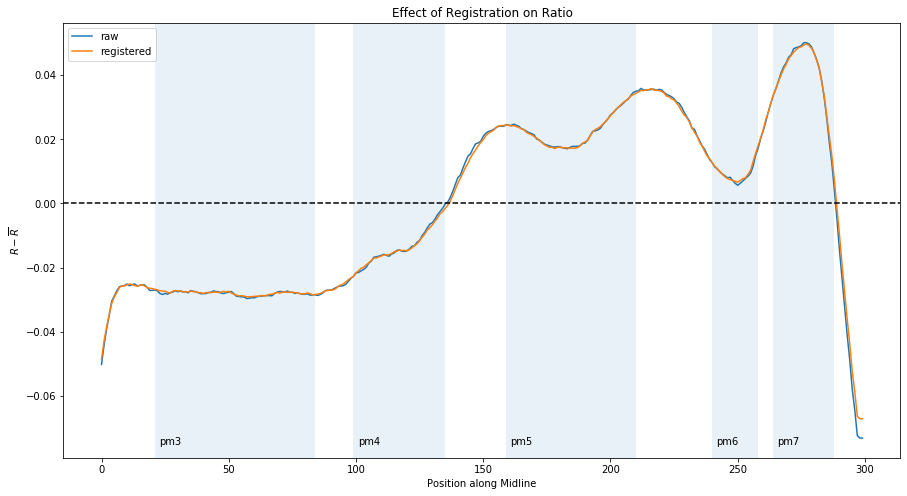

In [33]:
fig, ax1 = plt.subplots(figsize=(15,8))
plots.plot_profile_avg_with_bounds(
    (raw_prof.sel(wavelength='r') - raw_prof.sel(wavelength='r').mean(dim=['position'])).mean(dim='pair'), label='raw', ax=ax1)
plots.plot_profile_avg_with_bounds(
    (reg_prof.sel(wavelength='r') - reg_prof.sel(wavelength='r').mean(dim='position')).mean(dim='pair'), label='registered', ax=ax1)
ax1.legend()
plots.add_regions_to_axis(ax1, scaled_regions)
ax1.axhline(0, color='k', linestyle='--')
ax1.set_title('Effect of Registration on Ratio')
ax1.set_ylabel(r'$R - \overline{R}$');
ax1.set_xlabel(r'Position along Midline');

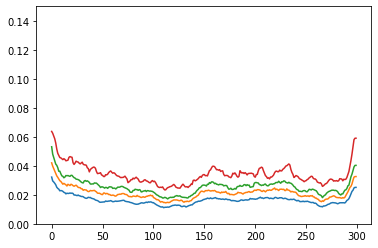

In [24]:
plt.plot(np.percentile(da.get_resid_rr(prof_sm_r)[nomove], 80, axis=0))
plt.plot(np.percentile(da.get_resid_rr(prof_sm_r)[nomove], 90, axis=0))
plt.plot(np.percentile(da.get_resid_rr(prof_sm_r)[nomove], 95, axis=0))
plt.plot(np.percentile(da.get_resid_rr(prof_sm_r)[nomove], 99, axis=0))
# plt.plot(np.percentile(da.get_resid_rr(data_single)[any_move], 95, axis=0))
plt.ylim([0, 0.15]);